In [1]:
import psycopg2
#import pandas as pd
import os
#from config import Config
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
# QQ Plot
import scipy.stats as stats
import pylab as py
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy

# declare a new PostgreSQL connection object
conn = psycopg2.connect("host=covid19.c9opif8xcrgf.us-east-1.rds.amazonaws.com dbname= user= password=")

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_us = pd.read_sql('SELECT province_state, country_region, date(last_update), confirmed, deaths,recovered,active, incident_rate, people_tested, people_hospitlized, mortality_rate, testing_rate, hospitalization_rate FROM csse_covid_19_data_us', conn)



In [3]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8517 entries, 0 to 8516
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   province_state        8517 non-null   object 
 1   country_region        8517 non-null   object 
 2   date                  8517 non-null   object 
 3   confirmed             8517 non-null   int64  
 4   deaths                8517 non-null   int64  
 5   recovered             6629 non-null   float64
 6   active                8508 non-null   float64
 7   incident_rate         8223 non-null   object 
 8   people_tested         8223 non-null   float64
 9   people_hospitlized    5092 non-null   float64
 10  mortality_rate        8379 non-null   object 
 11  testing_rate          8223 non-null   object 
 12  hospitalization_rate  5092 non-null   object 
dtypes: float64(4), int64(2), object(7)
memory usage: 865.1+ KB


In [4]:
#convert 'date' column to 'datetime' dtype
#df_us['last_update'] = df_us["last_update"].dt.strftime("%m-%d-%Y")
#df_us['last_update'] = pd.to_date(df_us['last_update'], format='%m-%d-%y')
df_us['province_state'] = df_us["province_state"].astype(str)
df_us['mortality_rate'] = df_us['mortality_rate'].astype(float)
df_us['incident_rate'] = df_us['incident_rate'].astype(float)
df_us['hospitalization_rate'] = df_us['hospitalization_rate'].astype(float)

In [5]:
df_us= df_us.sort_values(['province_state','date'], ascending=[True,True])

In [6]:
df_us['testing_rate'] = df_us['testing_rate'].astype(float)
#df_us['last_update'] = df_us['last_update'].astype('datetime64[ns]')

In [7]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8517 entries, 1636 to 5774
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   province_state        8517 non-null   object 
 1   country_region        8517 non-null   object 
 2   date                  8517 non-null   object 
 3   confirmed             8517 non-null   int64  
 4   deaths                8517 non-null   int64  
 5   recovered             6629 non-null   float64
 6   active                8508 non-null   float64
 7   incident_rate         8223 non-null   float64
 8   people_tested         8223 non-null   float64
 9   people_hospitlized    5092 non-null   float64
 10  mortality_rate        8379 non-null   float64
 11  testing_rate          8223 non-null   float64
 12  hospitalization_rate  5092 non-null   float64
dtypes: float64(8), int64(2), object(3)
memory usage: 931.5+ KB


In [8]:
df_us.head(15)

,province_state,country_region,date,confirmed,deaths,recovered,active,incident_rate,people_tested,people_hospitlized,mortality_rate,testing_rate,hospitalization_rate
1636,Alabama,US,2020-04-12,3563,93,NaN,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945
1691,Alabama,US,2020-04-13,3734,99,NaN,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886
825,Alabama,US,2020-04-14,3953,114,NaN,3839.0,84.305541,33117.0,493.0,2.883886,706.285508,12.471541
768,Alabama,US,2020-04-15,4075,118,NaN,3957.0,86.907433,34077.0,525.0,2.895706,726.759406,12.883436
2445,Alabama,US,2020-04-16,4345,133,NaN,4212.0,92.665716,36391.0,553.0,3.060990,776.110032,12.727273
2503,Alabama,US,2020-04-17,4571,148,NaN,4423.0,97.485613,37848.0,594.0,3.237804,807.183438,12.994968
1346,Alabama,US,2020-04-18,4712,153,NaN,4559.0,100.492717,42538.0,620.0,3.247029,907.206961,13.157895
1404,Alabama,US,2020-04-19,4888,157,NaN,4731.0,104.246265,45712.0,641.0,3.211948,974.898787,13.113748
8441,Alabama,US,2020-04-20,5079,163,NaN,4916.0,108.319718,45900.0,641.0,3.209293,978.908259,12.620595
523,Alabama,US,2020-04-21,5317,183,NaN,5134.0,113.395538,48526.0,699.0,3.441790,1034.912902,13.146511


# Outliers

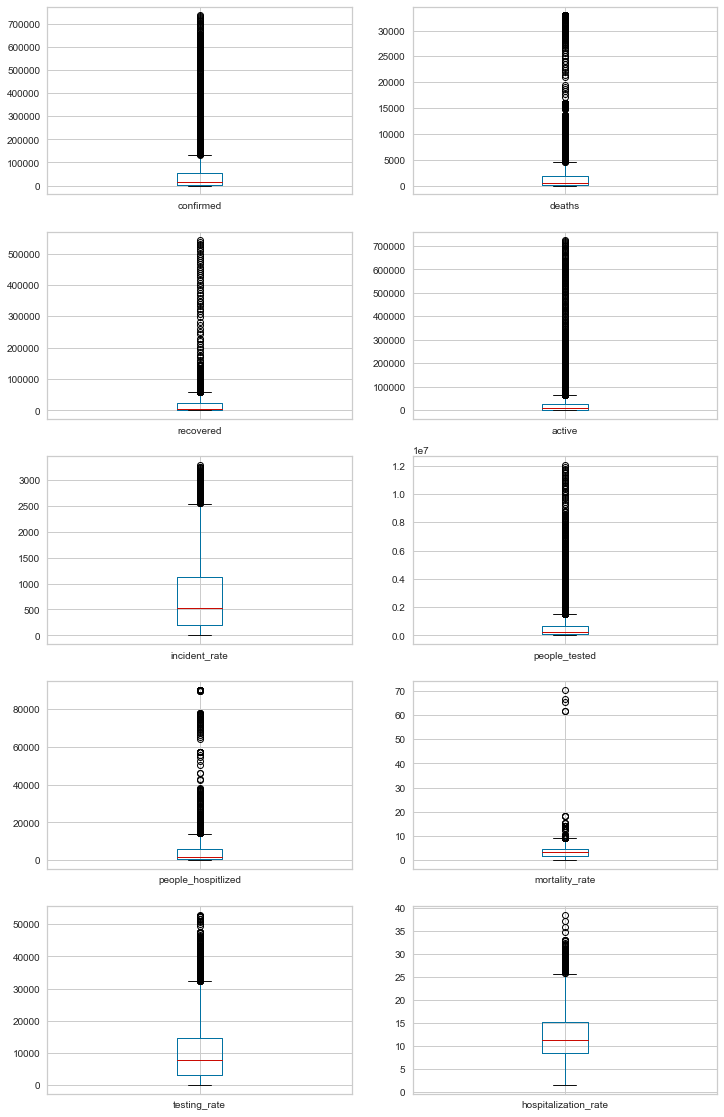

In [9]:
df_us.iloc[:, 2:].plot(kind='box', subplots=True, layout=(5,2), sharex=False, sharey=False, figsize=(12,20));
plt.show()

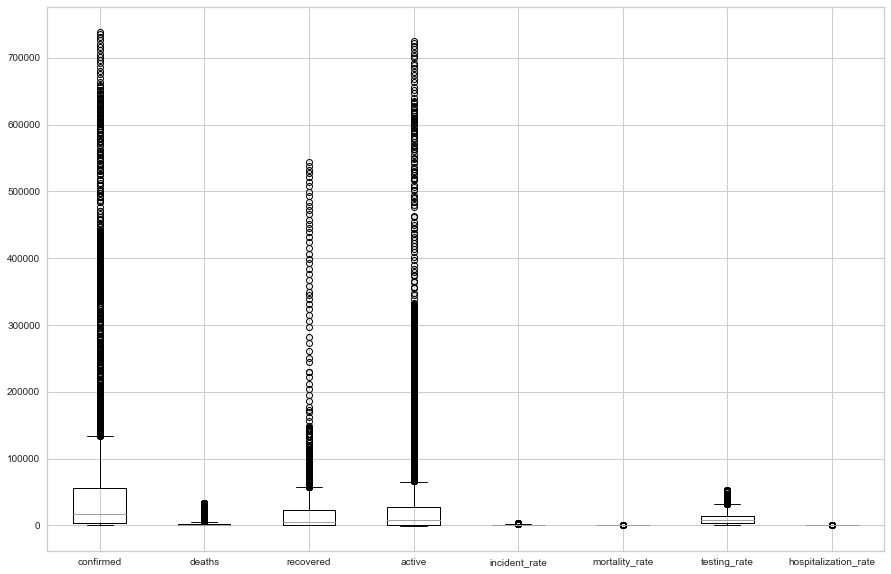

In [10]:
cont = ["confirmed", "deaths", "recovered", "active", "incident_rate","mortality_rate","testing_rate","hospitalization_rate"]
df_us[cont].boxplot(return_type="axes", figsize=(15,10))

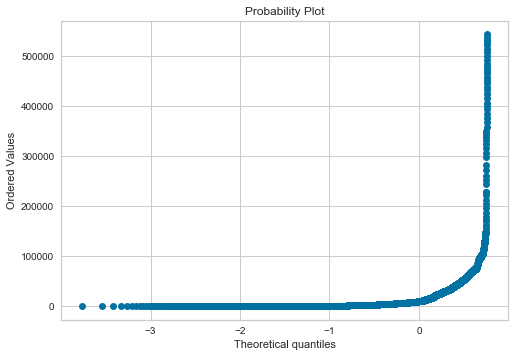

In [11]:
# QQ Plot of Recovered 
stats.probplot(df_us["recovered"], dist="norm", plot=py)
py.show()

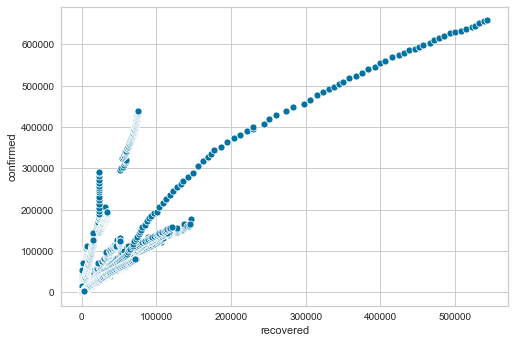

In [12]:
sns.scatterplot(x="recovered", y="confirmed", data=df_us)

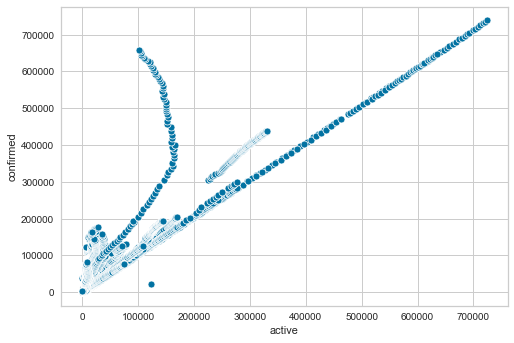

In [13]:
sns.scatterplot(x="active", y="confirmed", data=df_us)

In [14]:
"""
Retreive data for a particular feature from a specified state
"""
def get_state_info(df, state, feature):
    data = df[df['province_state']==state].loc[:, ['date', feature]]
    return data

"""
Calculate daily change from a list values already sorted by dates
"""
def daily_increase(data):
    return [data[i+1] - data[i] for i in range(len(data)-1)]


"""
Calculate moving average of data within a given window size
"""
def moving_avg(data, window_size=7):
    avg = []
    for i in range(len(data)):
        if i + window_size < len(data):
            avg.append(np.mean(data[i:i+window_size]))
        else:
            avg.append(np.mean(data[i:len(data)]))
    return avg

In [15]:
dates = df_us['date'].unique()
start_date = dates[0]
start_date
dates = df_us['date'].unique()
days_since_start = [(d- start_date).days for d in dates if d is not None ]
days_since_start[:5]

[0, 1, 2, 3, 4]

In [16]:
"""
Plot cumulative values of a feature by comparing states in a given list
"""
def plot_state_trend(states, feat, title=None, w_size=7, show_moving_avg=True):
    colors = ['red', 'blue', 'orange', 'green', 'black', 'yellow', 'purple', 'pink']
    
    legends = []
    plt.figure(figsize=(12, 9))

    for j in range(len(states)):
        state = states[j]
        color = colors[j]

        tmp = get_state_info(df_us, state, feat)
        raw = tmp[feat].to_list()
        if show_moving_avg:
            delta_slide_window = moving_avg(raw, w_size)

        plt.plot(days_since_start, raw, color=color, label=f'feat.title() ({state})')
        legends.append(state)

        if show_moving_avg:
            plt.plot(days_since_start, delta_slide_window, color=color, linestyle='dashed', label=f'{w_size} day avg')
            legends.append(f'{w_size}d-moving avg')

    plt.legend(legends, prop={'size': 8}, loc='upper left')
    plt.xlabel('Days since 2020-04-12', size=10)
    plt.xticks(size=10)
    plt.yticks(size=10)
    if title == None:
        title = feat.title()
    plt.title(title, size=30)
    plt.show()
  

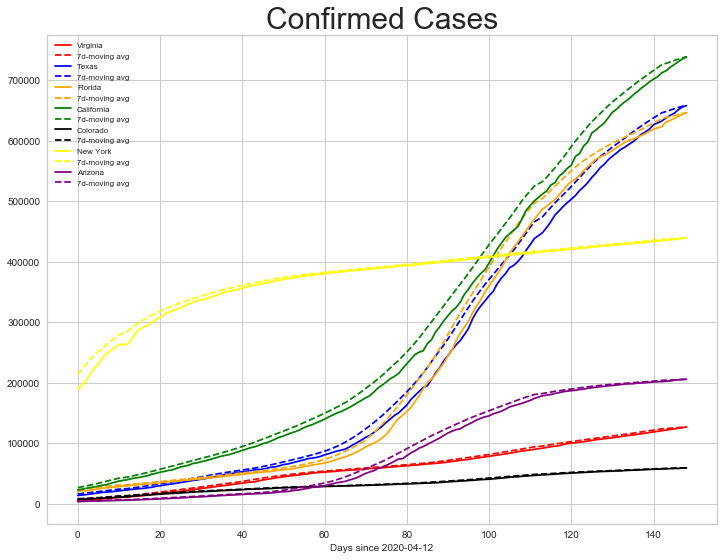

In [17]:
plot_state_trend(['Virginia', 'Texas', 'Florida', 'California', 'Colorado', 'New York', 'Arizona'], 
                 'confirmed', title='Confirmed Cases', show_moving_avg=True)

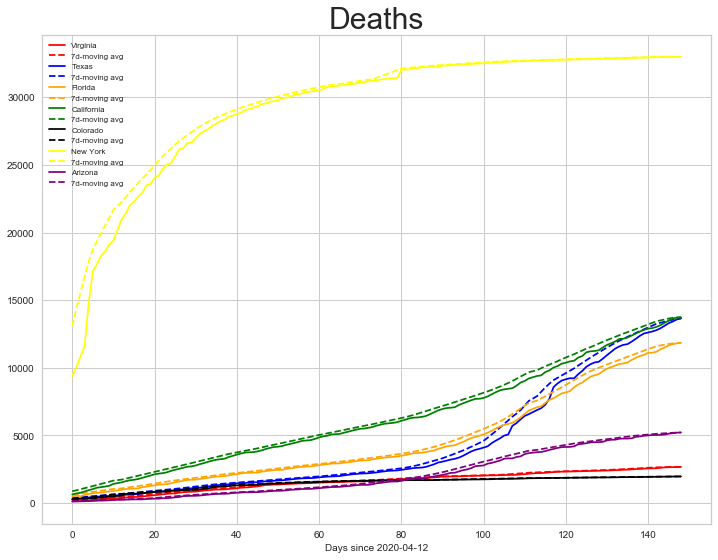

In [36]:
plot_state_trend(['Virginia', 'Texas', 'Florida', 'California', 'Colorado', 'New York', 'Arizona'], 
                 'deaths', title='Deaths', show_moving_avg=True)

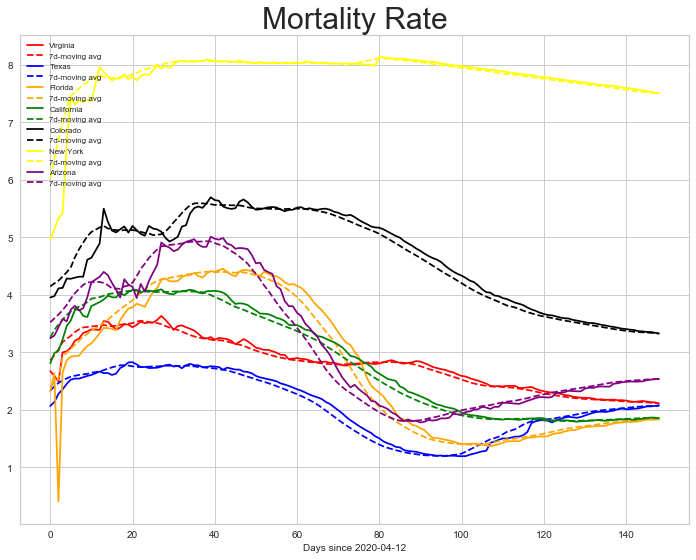

In [17]:
plot_state_trend(['Virginia', 'Texas', 'Florida', 'California', 'Colorado', 'New York', 'Arizona'], 
                 'mortality_rate', title='Mortality Rate', show_moving_avg=True)

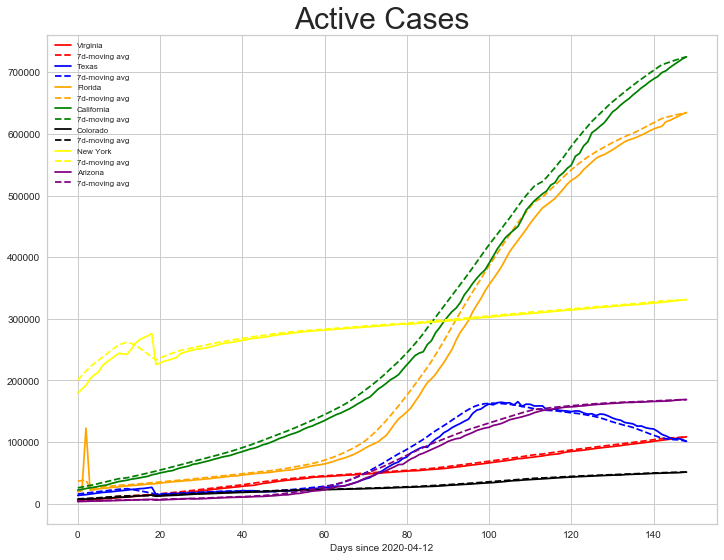

In [18]:
plot_state_trend(['Virginia', 'Texas', 'Florida', 'California', 'Colorado', 'New York', 'Arizona'], 
                 'active', title='Active Cases', show_moving_avg=True)

In [18]:
"""
Plot moving average and daily changes of a feature from a given state
"""
def plot_moving_avg(state, feat, title=None, w_size=7):
    info = get_state_info(df_us, state, feat)
    raw = info[feat].to_list()
    delta_daily = daily_increase(raw)
    delta_7day = moving_avg(delta_daily)

    plt.figure(figsize=(12, 9))
    adjusted_dates = days_since_start[:-1]
    plt.bar(adjusted_dates, delta_daily)
    plt.plot(adjusted_dates, delta_7day, color='orange', linestyle='dashed')

    plt.xlabel('Days since 2020-04-12', size=30)
    plt.legend([f'{w_size}-day moving avg', 'Daily Increase in {feat}'], prop={'size': 10}, loc='upper left')

    plt.xlabel('Days since 2020-04-12', size=10)
    plt.xticks(size=10)
    plt.yticks(size=10)
    if title==None:
        title = f'{state} Daily Increases in {feat.title()}'
    plt.title(title, size=30)
    plt.show()

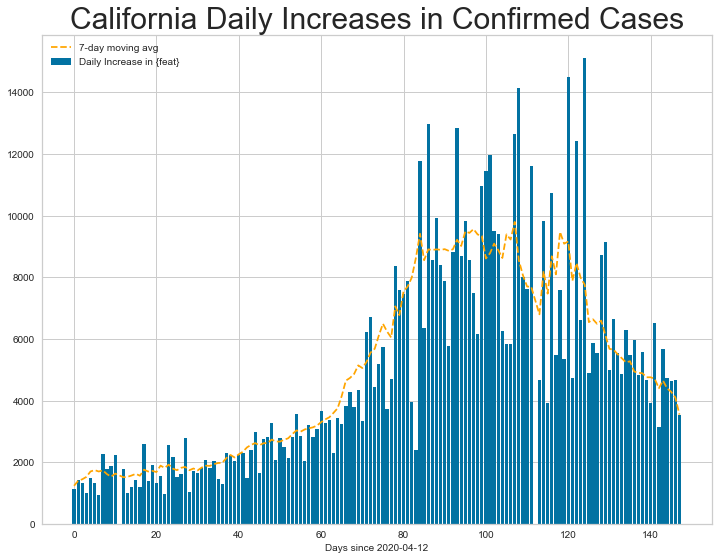

In [19]:
plot_moving_avg('California', 'confirmed', 'California Daily Increases in Confirmed Cases')

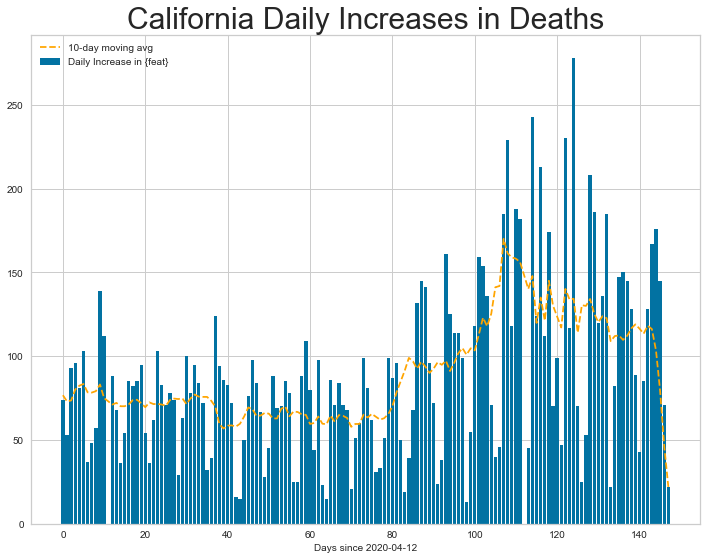

In [40]:
plot_moving_avg('California', 'deaths', 'California Daily Increases in Deaths', w_size=10)

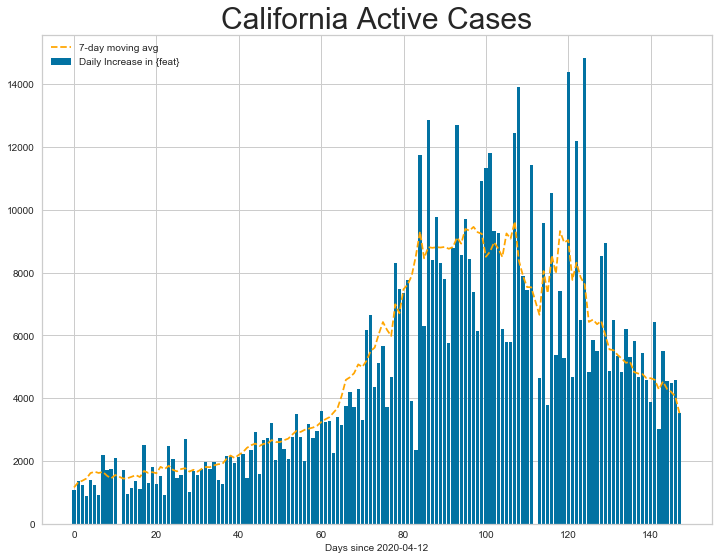

In [43]:
plot_moving_avg('California', 'active', title='California Active Cases')

# Machine Learning

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

In [51]:
np.array(days_since_start).shape
a_days = np.array(days_since_start).reshape(-1, 1)  # x in shape required for sklearn input format

[[  0]
 [  1]
 [  2]
 [  3]
 [  4]
 [  5]
 [  6]
 [  7]
 [  8]
 [  9]
 [ 10]
 [ 12]
 [ 13]
 [ 14]
 [ 15]
 [ 16]
 [ 17]
 [ 18]
 [ 19]
 [ 20]
 [ 21]
 [ 22]
 [ 23]
 [ 24]
 [ 25]
 [ 26]
 [ 27]
 [ 28]
 [ 29]
 [ 30]
 [ 31]
 [ 32]
 [ 33]
 [ 34]
 [ 35]
 [ 36]
 [ 37]
 [ 38]
 [ 39]
 [ 40]
 [ 41]
 [ 42]
 [ 43]
 [ 44]
 [ 45]
 [ 46]
 [ 47]
 [ 48]
 [ 49]
 [ 50]
 [ 51]
 [ 52]
 [ 53]
 [ 54]
 [ 55]
 [ 56]
 [ 57]
 [ 58]
 [ 59]
 [ 60]
 [ 61]
 [ 62]
 [ 63]
 [ 64]
 [ 65]
 [ 66]
 [ 67]
 [ 68]
 [ 69]
 [ 70]
 [ 71]
 [ 72]
 [ 73]
 [ 74]
 [ 75]
 [ 76]
 [ 77]
 [ 78]
 [ 79]
 [ 80]
 [ 81]
 [ 82]
 [ 83]
 [ 84]
 [ 85]
 [ 86]
 [ 87]
 [ 88]
 [ 89]
 [ 90]
 [ 91]
 [ 92]
 [ 93]
 [ 94]
 [ 95]
 [ 96]
 [ 97]
 [ 98]
 [ 99]
 [100]
 [101]
 [102]
 [103]
 [104]
 [105]
 [106]
 [107]
 [108]
 [109]
 [110]
 [111]
 [113]
 [114]
 [115]
 [116]
 [117]
 [118]
 [119]
 [120]
 [121]
 [122]
 [123]
 [124]
 [125]
 [126]
 [127]
 [128]
 [129]
 [130]
 [131]
 [132]
 [133]
 [134]
 [135]
 [136]
 [137]
 [138]
 [139]
 [140]
 [141]
 [142]
 [143]
 [144]

In [22]:
"""
Prepare input data by splitting it into training and testing data
"""
def prep_training(state, feat, test_size=0.2, shuffle=True):
    info = get_state_info(df_us, state, feat)
    x = a_days
    y = info[feat]
    x_train, x_test, y_train, y_test = train_test_split(x, y.to_numpy(), test_size=test_size, shuffle=shuffle)
    print(f"x_test:{x_test.shape}, y_test:{y_test.shape}")
    print(f"x_train:{x_train.shape}, y_train:{y_train.shape}")
    
    return x, y, x_train, y_train, x_test, y_test


"""
Function to sort (x,y) pair in the order of increasing values of x. 
This is used to fix the problem of line plot on shuffled x-coord (days)
"""
def sort_plot_coords(x,y):
    sorted_l=sorted(list(zip(x,y)), key=lambda z: z[0][0])
    x_sorted, y_sorted = zip(*sorted_l)
    return x_sorted, y_sorted


"""
Fit given regression model on the training data and plot the test data along with the regression line
"""
def fit(regr, x_train, y_train, x_test, y_test, sort_coords=False): 
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)

    # The mean squared error
    print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.2f}')
    # The coefficient of determination: 1 is perfect prediction
    print(f'Coefficient of determination (R2): {r2_score(y_test, y_pred):.2f}')

    plt.scatter(x_test, y_test, color='black')
    
    if sort_coords:
        x_test, y_pred = sort_plot_coords(x_test, y_pred)
    plt.plot(x_test, y_pred, color='blue', linewidth=1)
    
    plt.show()
    
    return y_pred


"""
Predict future using the trained regression model, plot the original data and future predtions along with the 
regression line. The prediction is returned as a data frame
"""
def predict(regr, x, y, x_test, y_pred, days_since_start, start_date, days_in_future = 10, digits=2):
    new_x = np.array([i for i in range(len(days_since_start)+days_in_future)]).reshape(-1, 1)
    pred = regr.predict(new_x)
    future_x = new_x[-days_in_future:]
    future_pred = pred[-days_in_future:]
    
    plt.scatter(x, y, color='black')
    plt.scatter(future_x, future_pred, color='red')
    
    plt.plot(new_x[:-days_in_future], pred[:-days_in_future], color='blue', linewidth=1)
    plt.show()
    
    ## Get df
    dates =[]
    for d in future_x:
        cur_date = start_date + datetime.timedelta(int(d[0]))
        dates.append(str(cur_date))
        
    ## format to given precision
    vals = [f'{x:.{digits}f}' for x in future_pred]
    
    return pd.DataFrame({'Date': dates, 'Future':vals})

# California Mortality Rate

In [44]:
x, y, x_train, y_train, x_test, y_test = prep_training('California', 'mortality_rate')

x_test:(30, 1), y_test:(30,)
x_train:(117, 1), y_train:(117,)


# Linear Regression

Mean squared error: 0.16
Coefficient of determination (R2): 0.80


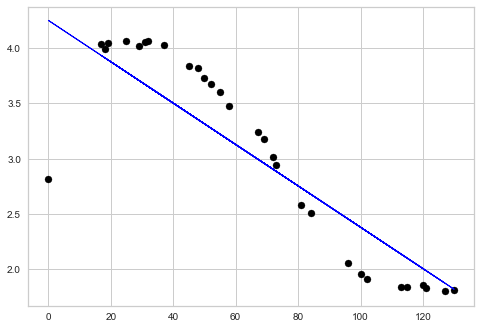

Linear coefficients: 
 [-0.01872838]


In [45]:
regr_linear = LinearRegression()
y_pred = fit(regr_linear, x_train, y_train, x_test, y_test)

print('Linear coefficients: \n', regr_linear.coef_)

Future Forecast

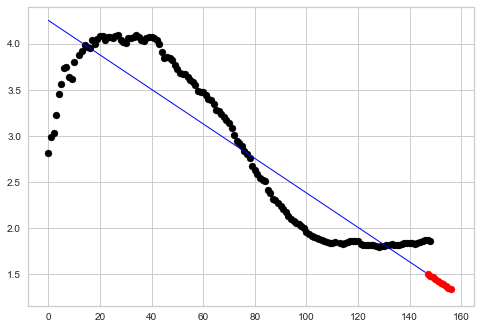

,Date,Future
0,2020-09-06,1.50
1,2020-09-07,1.48
2,2020-09-08,1.46
3,2020-09-09,1.44
4,2020-09-10,1.42
5,2020-09-11,1.41
6,2020-09-12,1.39
7,2020-09-13,1.37
8,2020-09-14,1.35
9,2020-09-15,1.33


In [46]:
predict(regr_linear, x, y, x_test, y_pred, days_since_start, start_date)

# SVM

x_test:(30, 1), y_test:(30,)
x_train:(117, 1), y_train:(117,)
Mean squared error: 0.51
Coefficient of determination (R2): 0.18


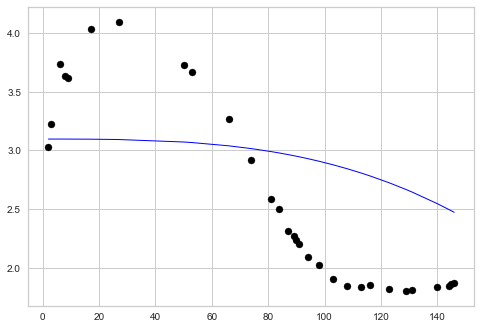

In [47]:
x, y, x_train, y_train, x_test, y_test = prep_training('California', 'mortality_rate', shuffle=True)
regr_svm = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
y_pred2 = fit(regr_svm, x_train, y_train, x_test, y_test, sort_coords=True)

Prediction for future 10 days

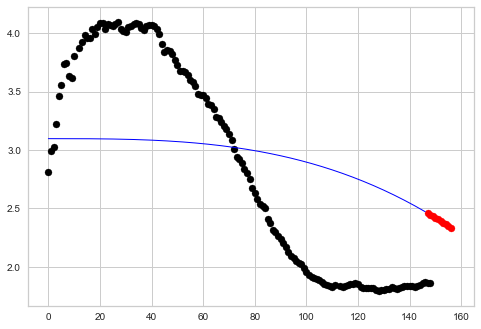

,Date,Future
0,2020-09-06,2.46
1,2020-09-07,2.45
2,2020-09-08,2.43
3,2020-09-09,2.42
4,2020-09-10,2.41
5,2020-09-11,2.39
6,2020-09-12,2.38
7,2020-09-13,2.36
8,2020-09-14,2.35
9,2020-09-15,2.34


In [48]:
predict(regr_svm, x, y, x_test, y_pred2, days_since_start, start_date)

# Polylinear Regression

x_test:(15, 1), y_test:(15,)
x_train:(132, 1), y_train:(132,)
Mean squared error: 0.01
Coefficient of determination (R2): 0.99


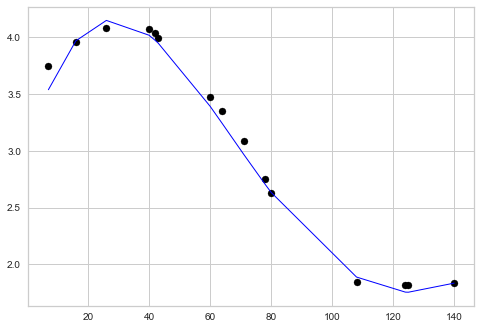

In [49]:
x, y, x_train, y_train, x_test, y_test = prep_training('California', 'mortality_rate', test_size=0.1, shuffle=True)
# plt.plot(x,y)
degree = 4

polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
y_pred3 = fit(polyreg, x_train, y_train, x_test, y_test, sort_coords=True)

Prediction for Future 10 days

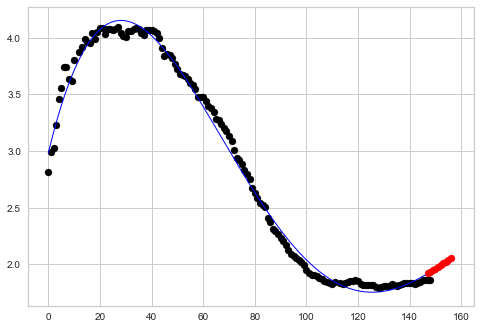

,Date,Future
0,2020-09-06,1.92
1,2020-09-07,1.93
2,2020-09-08,1.95
3,2020-09-09,1.96
4,2020-09-10,1.98
5,2020-09-11,1.99
6,2020-09-12,2.01
7,2020-09-13,2.03
8,2020-09-14,2.04
9,2020-09-15,2.06


In [50]:
predict(polyreg, x, y, x_test, y_pred3, days_since_start, start_date)